<a href="https://colab.research.google.com/github/Logeeshr/streamlit/blob/main/Item_demand_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
#Libraries for Data Cleaning
import pandas as pd
import numpy as np
import datetime

#Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#libraries to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for Model Building
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor as XGB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Libraries for Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# **Data Importing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Item_demand.csv")

In [4]:
#printing first 5 rows
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
print("Number of Rows in the dataset: ",df.shape[0])
print("Number of columns in the dataset: ",df.shape[1])


Number of Rows in the dataset:  913000
Number of columns in the dataset:  4


In [6]:
#checking any missing values in dataset
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
#statistical Information 
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
#checking the data type and number of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
#data_type of date column is object ----> converting into data column to data data_types
df["date"] = pd.to_datetime(df["date"])

In [10]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [11]:
#deleting dulipcate rows
df=df.drop_duplicates()

In [12]:
#Grouping the data itemwise and aggregating on sales column 
df = df.groupby(['item','date']).agg({'sales':'sum'}).reset_index()
df = df.set_index('date',drop = True)
df

,item,sales
date,,
2013-01-01,1,133
2013-01-02,1,99
2013-01-03,1,127
2013-01-04,1,145
2013-01-05,1,149
...,...,...
2017-12-27,50,511
2017-12-28,50,587
2017-12-29,50,596


In [13]:
#rolling sum for 90 days since we are going to predict the next three month sales
df_agg = df.groupby(['item']).rolling(90).sum().shift(-90).dropna().reset_index()
df_agg

,item,date,sales
0,1,2013-01-01,12848.0
1,1,2013-01-02,12936.0
2,1,2013-01-03,13019.0
3,1,2013-01-04,13103.0
4,1,2013-01-05,13153.0
...,...,...,...
86844,50,2017-09-28,62200.0
86845,50,2017-09-29,61962.0
86846,50,2017-09-30,61687.0
86847,50,2017-10-01,61392.0


# **Data Visualization(EDA)**

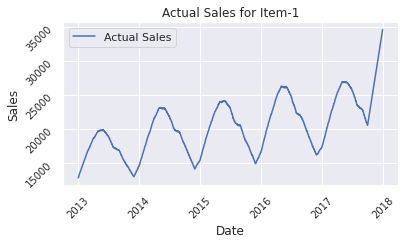

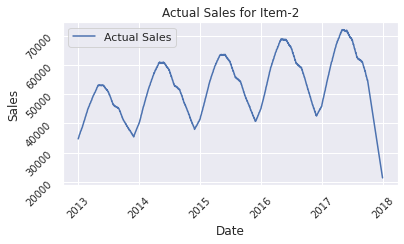

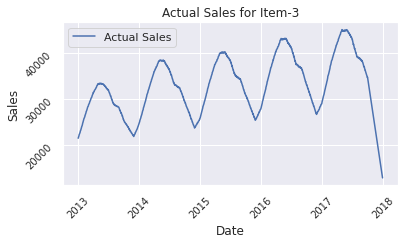

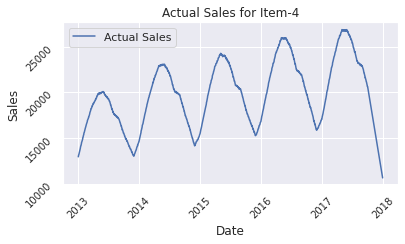

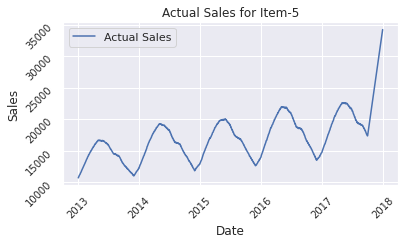

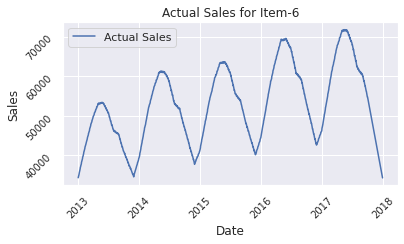

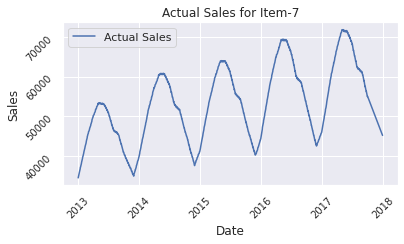

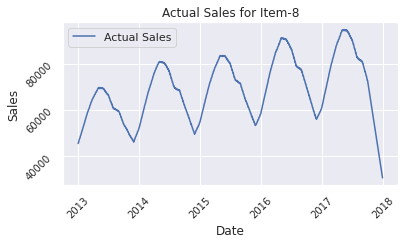

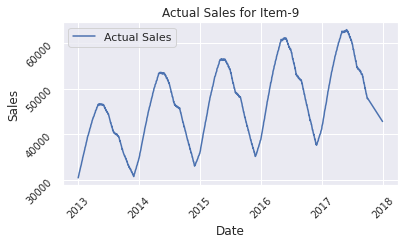

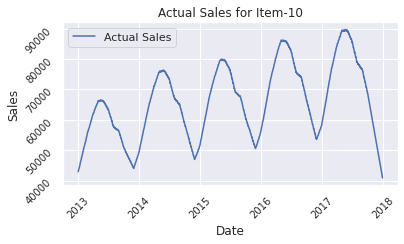

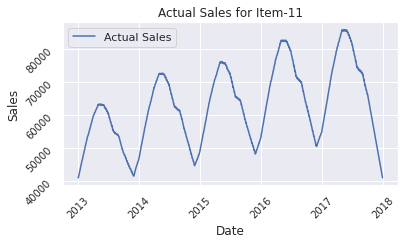

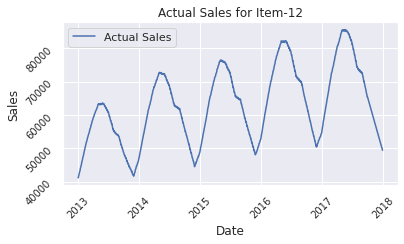

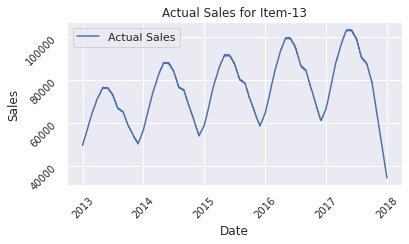

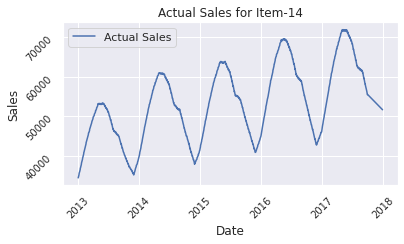

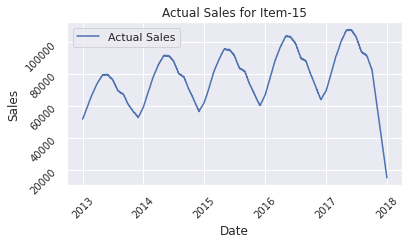

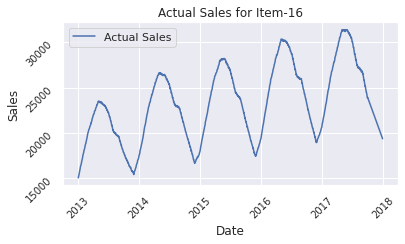

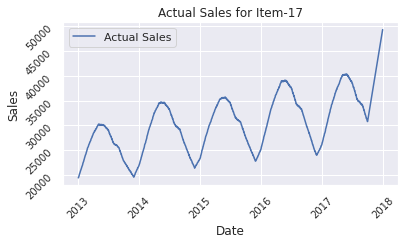

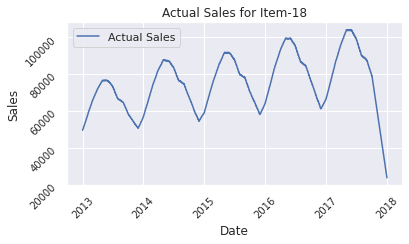

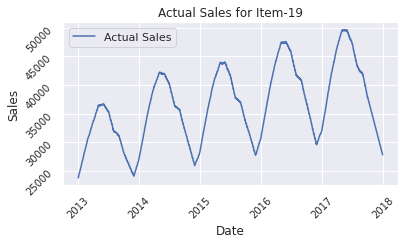

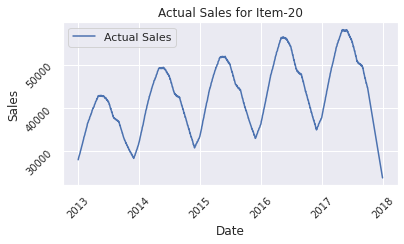

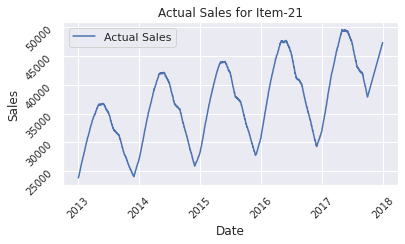

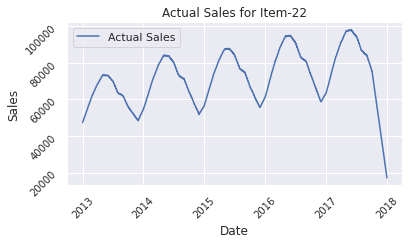

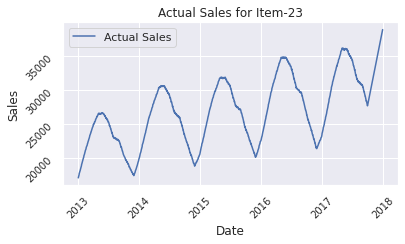

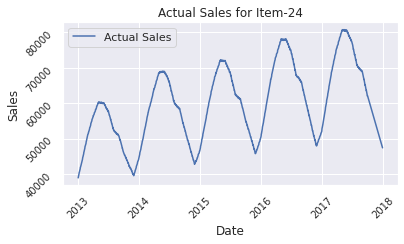

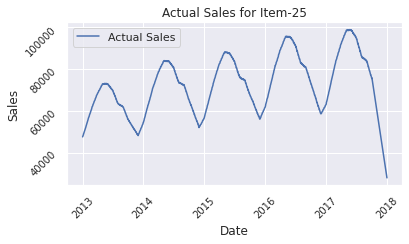

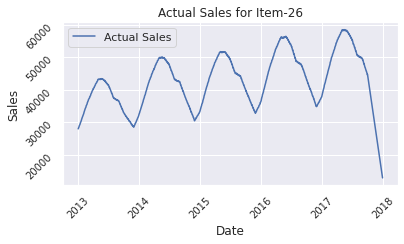

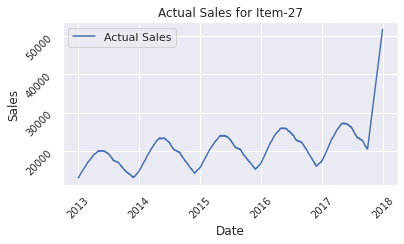

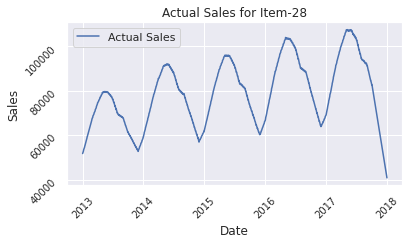

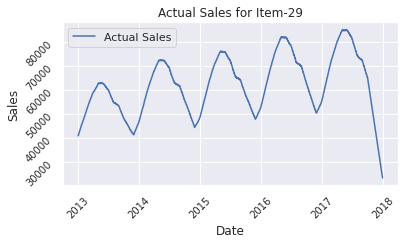

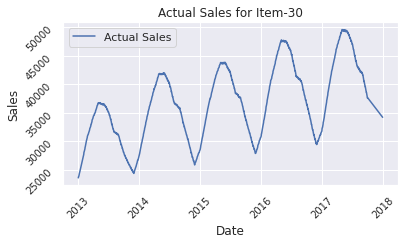

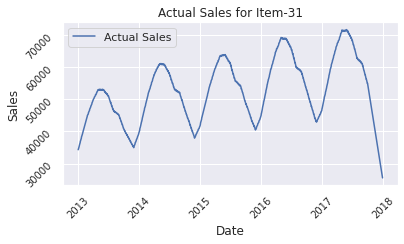

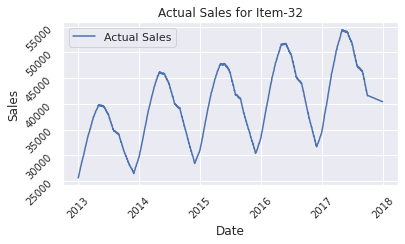

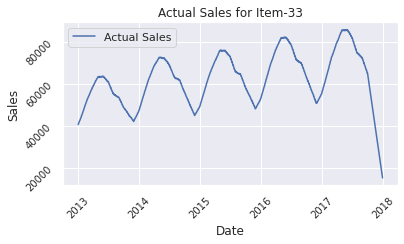

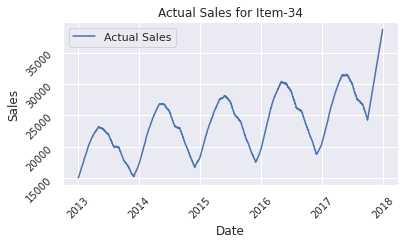

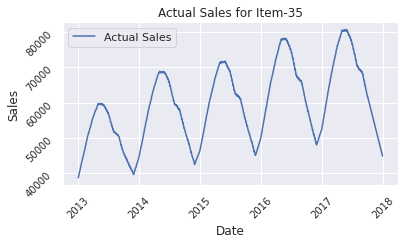

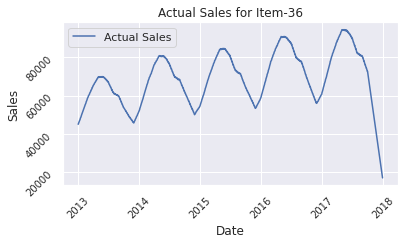

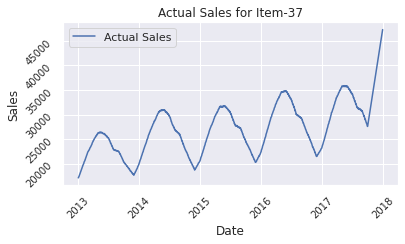

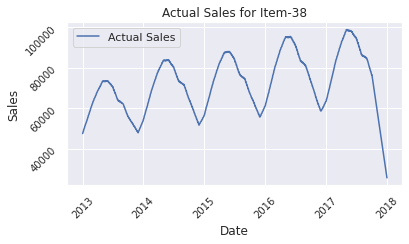

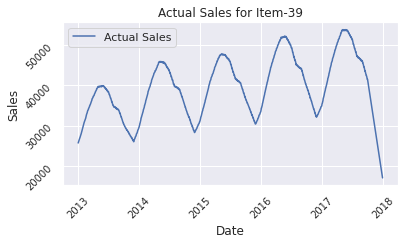

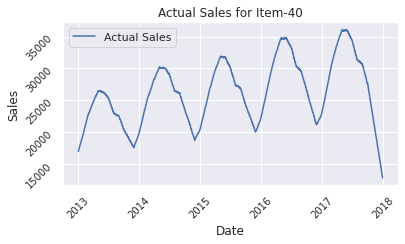

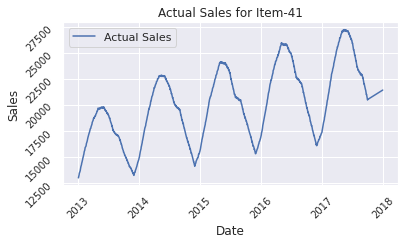

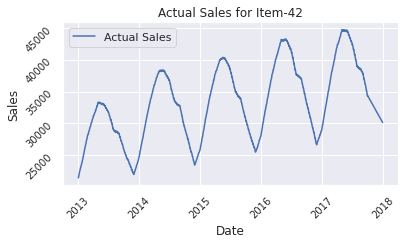

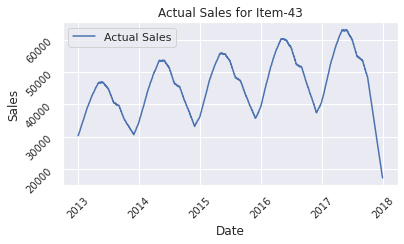

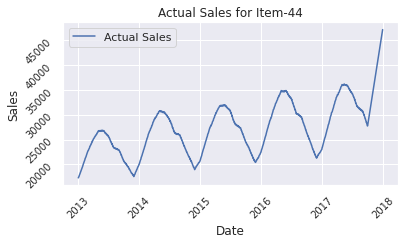

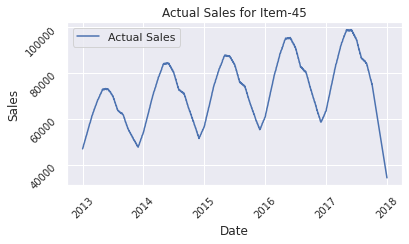

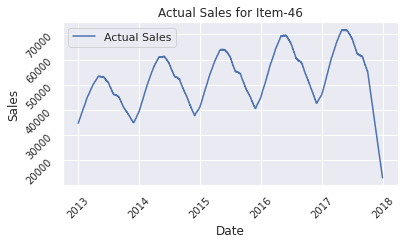

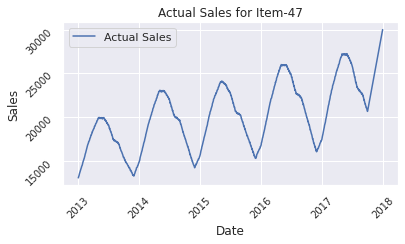

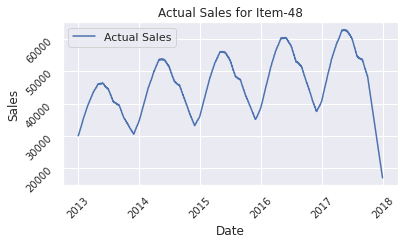

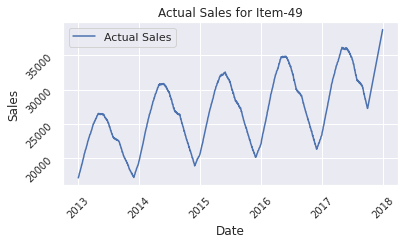

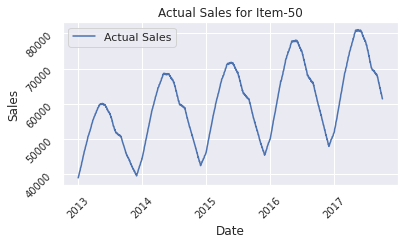

In [14]:
#visualizing the actual sales for every ite
for i in range(1,51): 
  plot_df = df_agg.loc[df_agg['item'] == i]
  plt.figure(figsize=(6,3))
  plt.plot(plot_df['date'], plot_df['sales'], label='Actual Sales')
  plt.title('Actual Sales for Item-{}'.format(i), size=12)
  plt.xlabel('Date', size=12)
  plt.ylabel('Sales', size=12)
  plt.xticks(rotation=45, size=10)
  plt.yticks(rotation=45, size=10)
  plt.legend(loc='best')
  plt.show()

From the Above graphs, we can clearly see that in the **mid of the every year sales is at peak** for that particular item 

**Feature Engineering**

In [15]:
df_agg = df_agg.set_index('date', drop=True)

In [16]:
df_agg

,item,sales
date,,
2013-01-01,1,12848.0
2013-01-02,1,12936.0
2013-01-03,1,13019.0
2013-01-04,1,13103.0
2013-01-05,1,13153.0
...,...,...
2017-09-28,50,62200.0
2017-09-29,50,61962.0
2017-09-30,50,61687.0


In [17]:
#Extracting more features from date column
df_agg = df_agg.reset_index()
df_agg['day_of_month'] = df_agg['date'].dt.day
df_agg['month'] = df_agg['date'].dt.month
df_agg['year'] = df_agg['date'].dt.year
df_agg['wk_of_year'] = df_agg['date'].dt.weekofyear
df_agg['quarter'] = df_agg['date'].dt.quarter
df_agg['is_month_start'] = df_agg['date'].dt.is_month_start.astype(int)
df_agg['is_month_end'] = df_agg['date'].dt.is_month_end.astype(int)
df_agg['is_quarter_start'] = df_agg['date'].dt.is_quarter_start.astype(int)
df_agg['is_quarter_end'] = df_agg['date'].dt.is_quarter_end.astype(int)

In [18]:
df_agg.head()

,date,item,sales,day_of_month,month,year,wk_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,2013-01-01,1,12848.0,1,1,2013,1,1,1,0,1,0
1,2013-01-02,1,12936.0,2,1,2013,1,1,0,0,0,0
2,2013-01-03,1,13019.0,3,1,2013,1,1,0,0,0,0
3,2013-01-04,1,13103.0,4,1,2013,1,1,0,0,0,0
4,2013-01-05,1,13153.0,5,1,2013,1,1,0,0,0,0


In [19]:
df_agg = df_agg.set_index('date',drop=True)
df_agg.head()

,item,sales,day_of_month,month,year,wk_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
date,,,,,,,,,,,
2013-01-01,1,12848.0,1,1,2013,1,1,1,0,1,0
2013-01-02,1,12936.0,2,1,2013,1,1,0,0,0,0
2013-01-03,1,13019.0,3,1,2013,1,1,0,0,0,0
2013-01-04,1,13103.0,4,1,2013,1,1,0,0,0,0
2013-01-05,1,13153.0,5,1,2013,1,1,0,0,0,0


# **Model Building**

## **Decision Tree model**

In [22]:
#separate dataset for decison model
df_agg_dt = df_agg.copy()
df_agg_dt.head()

,item,sales,day_of_month,month,year,wk_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
date,,,,,,,,,,,
2013-01-01,1,12848.0,1,1,2013,1,1,1,0,1,0
2013-01-02,1,12936.0,2,1,2013,1,1,0,0,0,0
2013-01-03,1,13019.0,3,1,2013,1,1,0,0,0,0
2013-01-04,1,13103.0,4,1,2013,1,1,0,0,0,0
2013-01-05,1,13153.0,5,1,2013,1,1,0,0,0,0


In [23]:
# dictionary for collecting the test data forecast results
test_forecast_dict_dt = dict()

# dictionary for collecting the evaluation metrics of the test forecast
em_dict_dt = dict()

In [24]:
# running a for loop for 50 items
for i in list(df_agg_dt['item'].unique()):
 
  # filtering the data item-wise
  split_data_dt = df_agg_dt[df_agg_dt['item']==i].drop(['item'], axis=1)
  #print(split_data)
  
  # Splitting the dataset into dependent and independent variable
  x_dt = split_data_dt.drop(['sales'], axis=1)
  y_dt = split_data_dt['sales']
  
  #since it is a time series dataset we should split the train and test data 
  #Taking 2013 to 2016 data as train data
  #Taking 2017 data as test data

  x_train_dt = x_dt.loc[:'2016-12-31']
  x_test_dt = x_dt.loc['2017-01-01':'2017-10-02'] 
  y_train_dt = y_dt.loc[:'2016-12-31']
  y_test_dt = y_dt.loc['2017-01-01':'2017-10-02']

  # Initializing the model
  dtr_model = DecisionTreeRegressor(max_depth=10)
  
  # Fitting the data 
  dtr_model.fit(x_train_dt, y_train_dt)
  
  # predicting the test data
  y_pred_dt = dtr_model.predict(x_test_dt)

  # creating key and value for test_forecast dictionary
  k = 'Item_'+str(i) #key
  v = y_pred_dt #value
  
  test_forecast_dict_dt.update({k:v})

  #Evaluation Metrics
  r2_dt = r2_score(y_test_dt, y_pred_dt)
  mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
  rmse_dt = np.sqrt(mse_dt)
  mae_dt = mean_absolute_error(y_test_dt, y_pred_dt)
  mape_dt = mean_absolute_percentage_error(y_test_dt, y_pred_dt)

  key_dt = 'Item_'+str(i)
  value_dt = {'r2':r2_dt, 'MSE':mse_dt, 'RMSE':rmse_dt, 'MAE':mae_dt, 'MAPE':mape_dt}
  em_dict_dt.update({key_dt:value_dt})

In [25]:
# creating a dataframe from dictionary 
test_forecast_dict_dt_df = pd.DataFrame(test_forecast_dict_dt, index=[pd.date_range(start='2017-01-01', end='2017-10-02')])
test_forecast_dict_dt_df = test_forecast_dict_dt_df.reset_index()

In [26]:
test_forecast_dict_dt_df = test_forecast_dict_dt_df.set_index('level_0', drop=True)

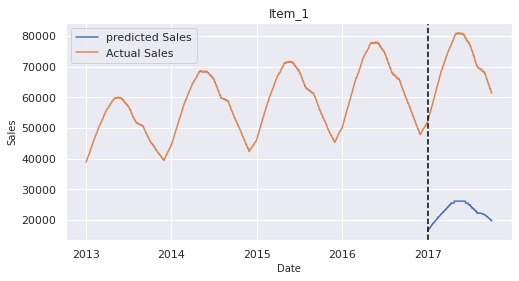

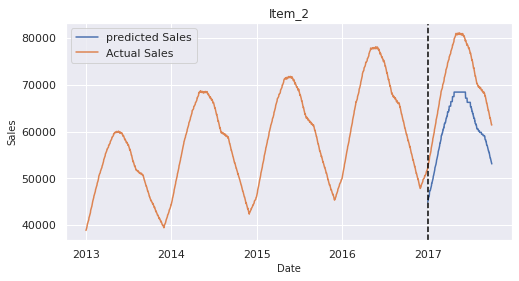

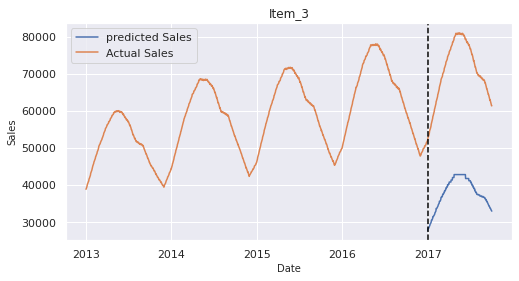

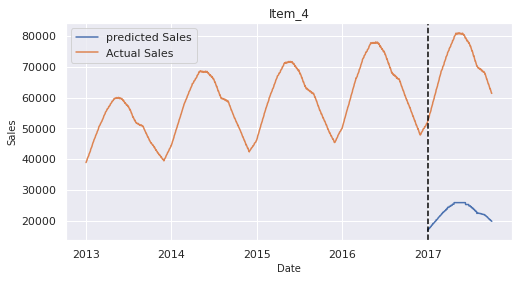

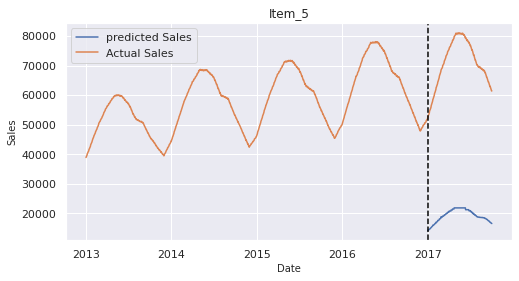

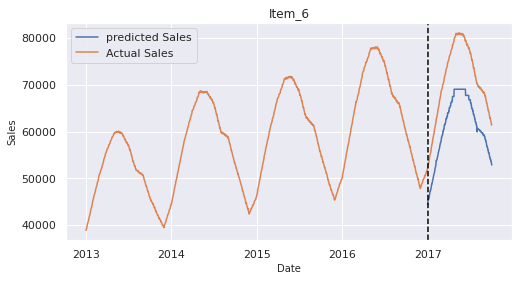

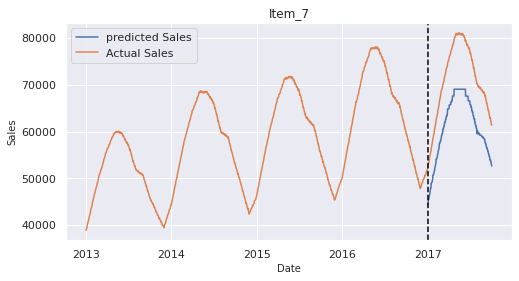

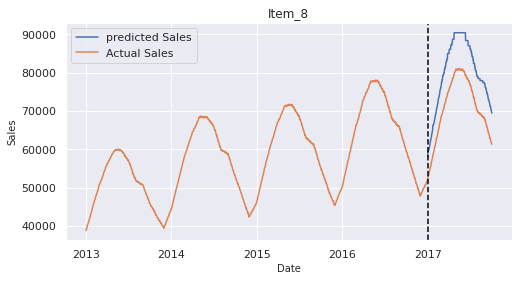

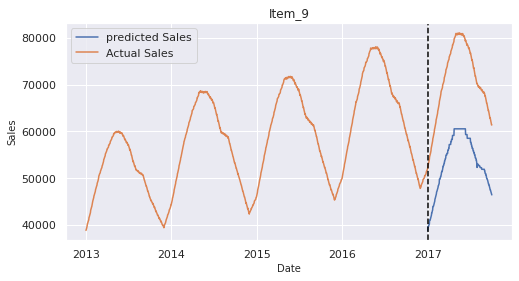

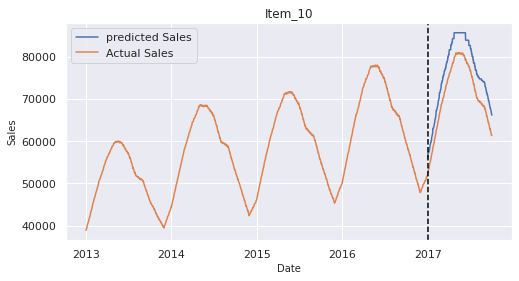

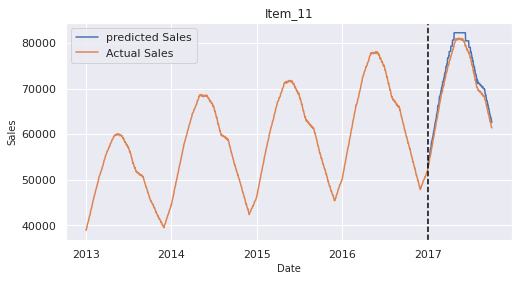

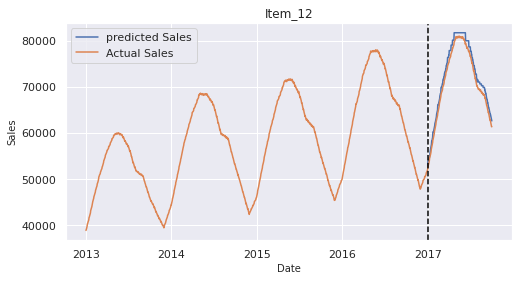

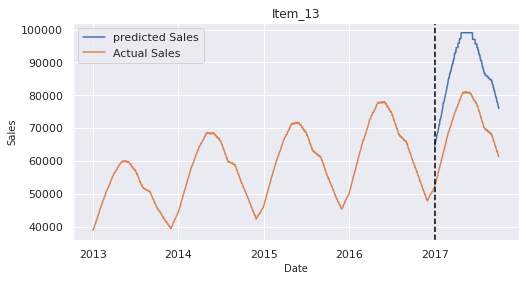

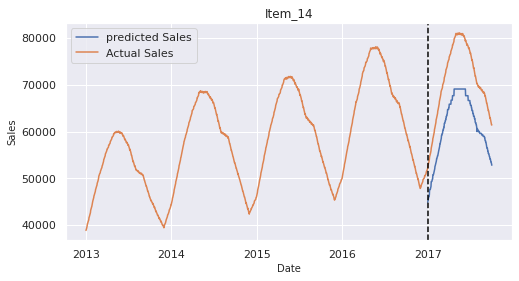

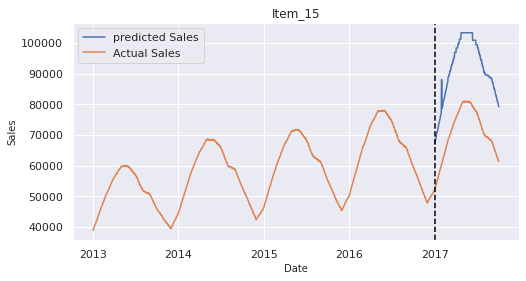

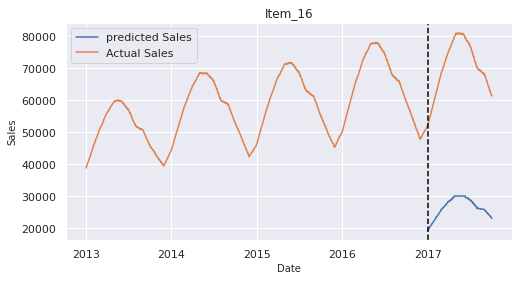

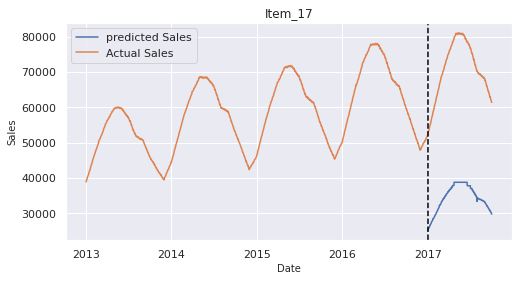

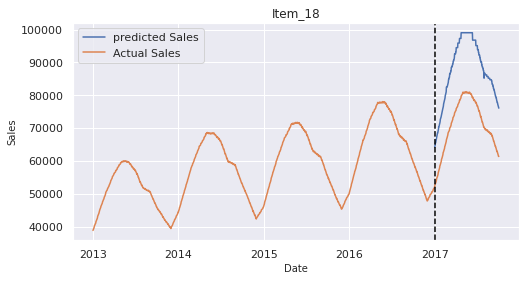

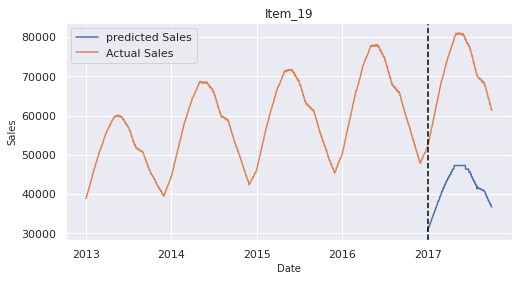

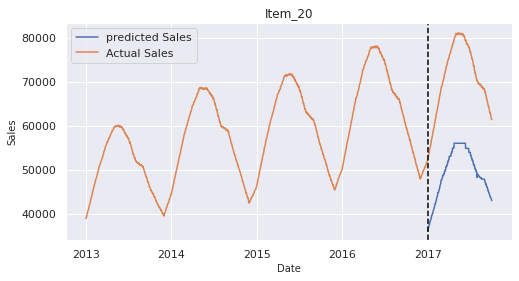

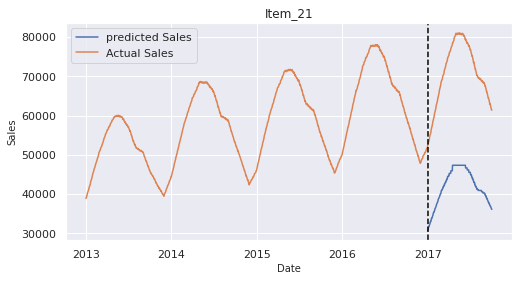

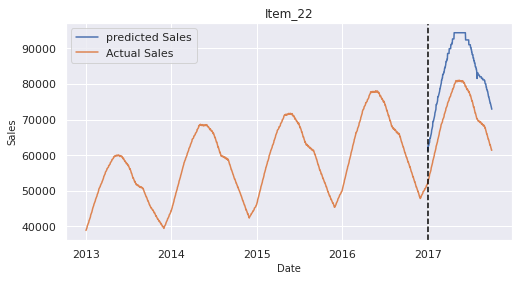

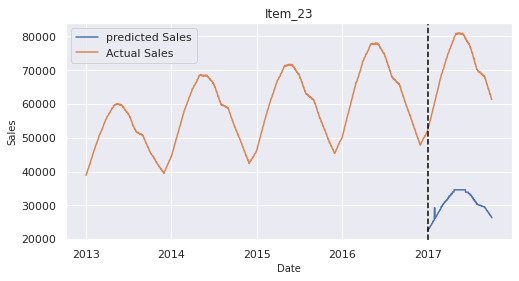

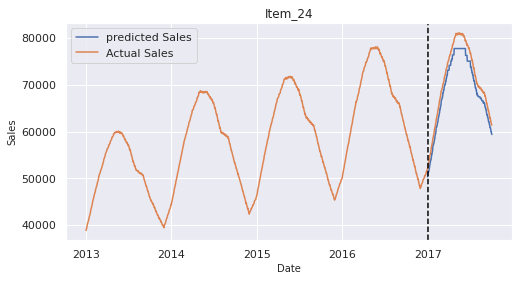

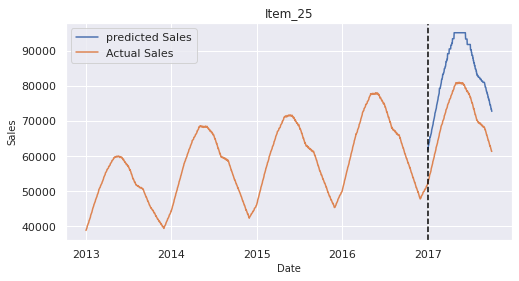

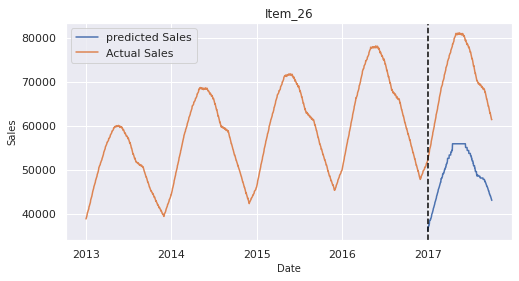

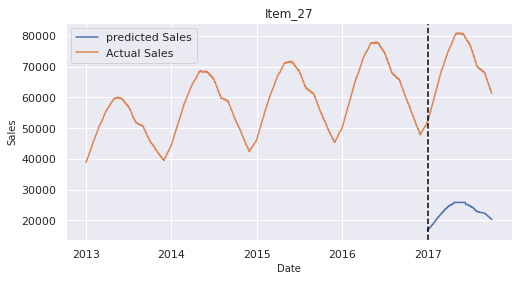

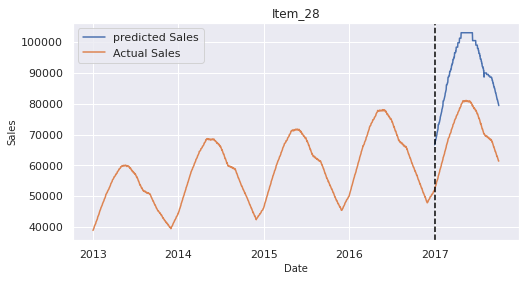

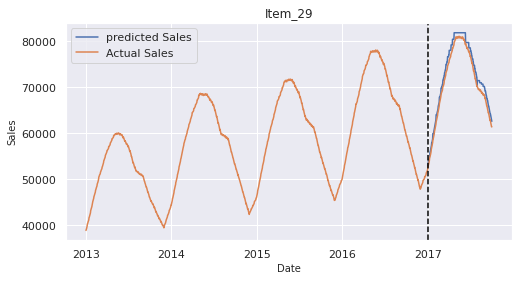

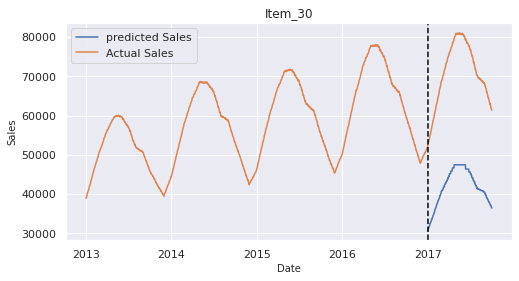

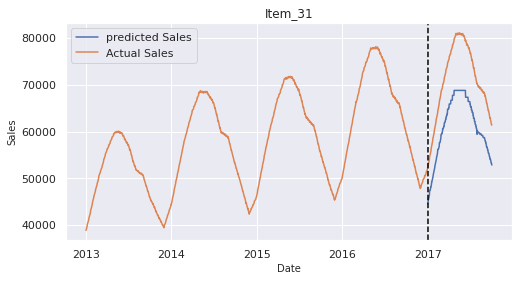

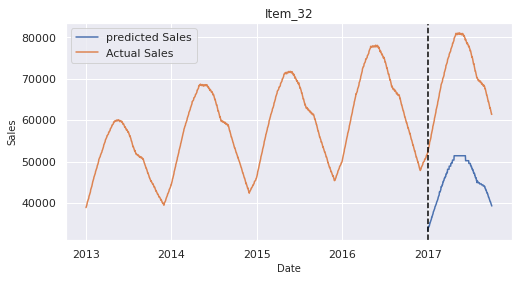

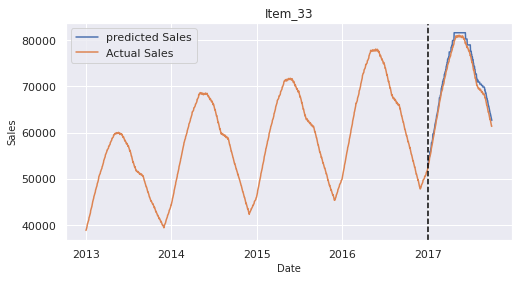

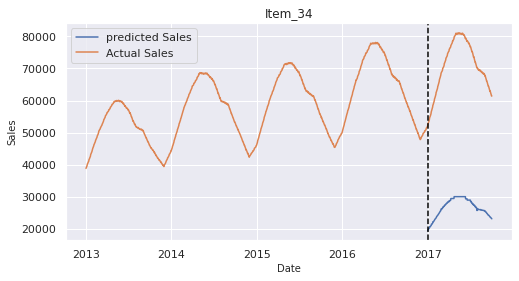

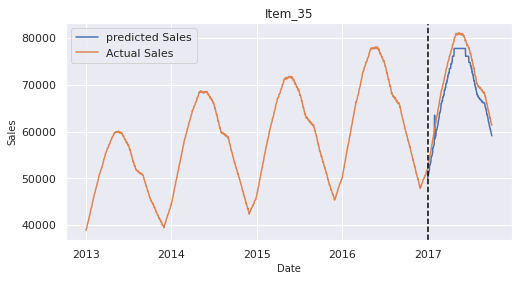

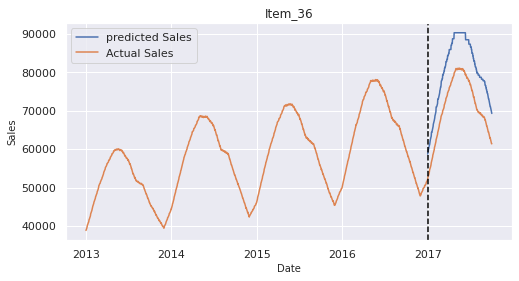

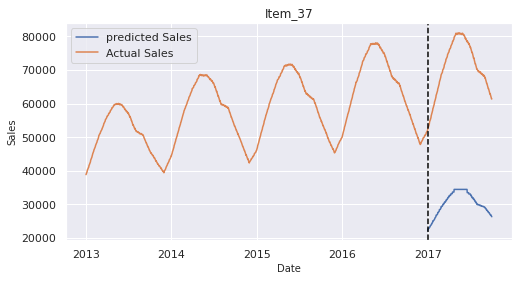

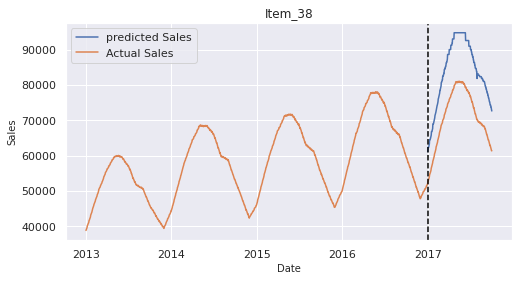

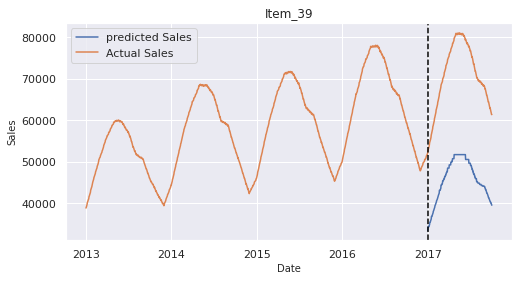

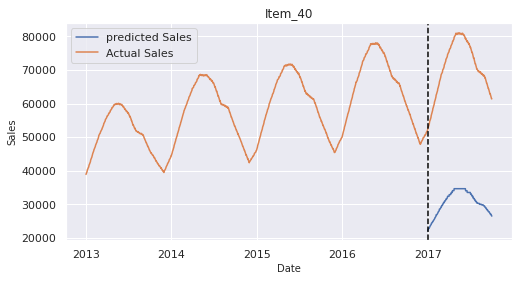

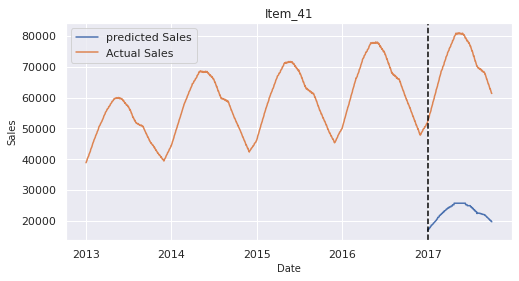

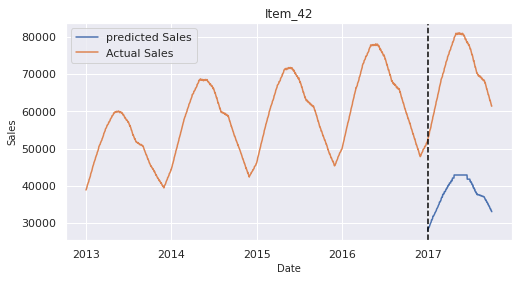

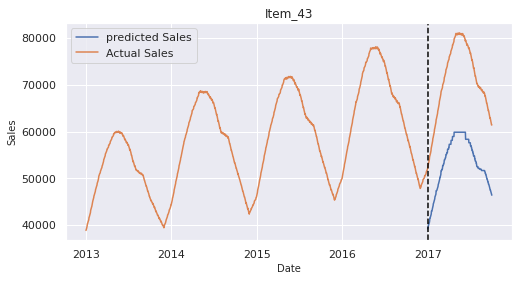

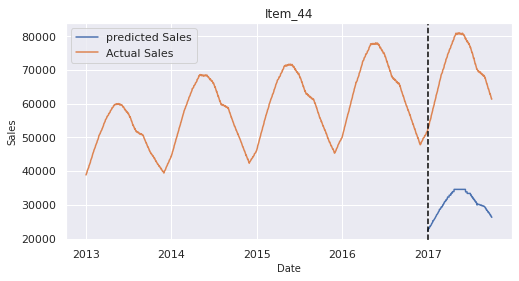

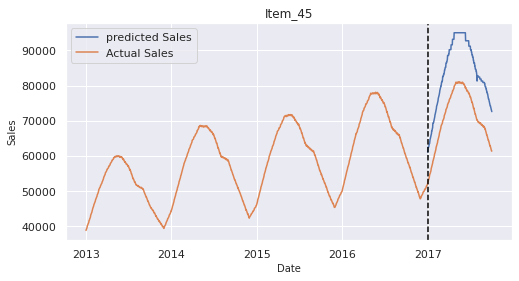

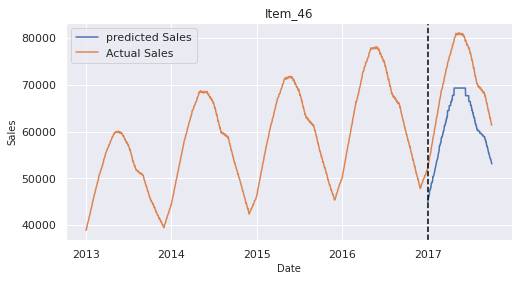

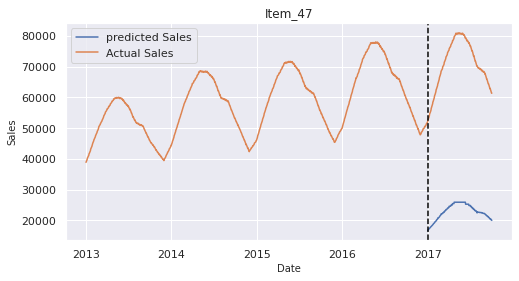

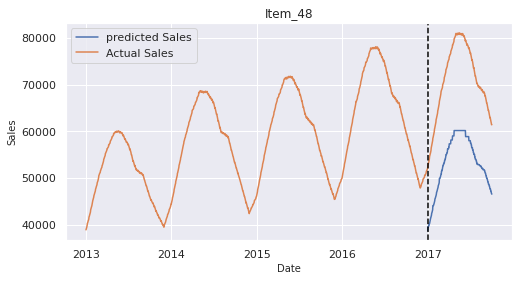

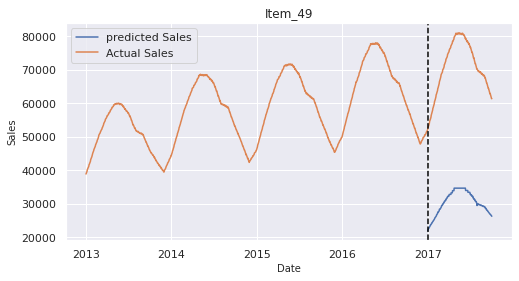

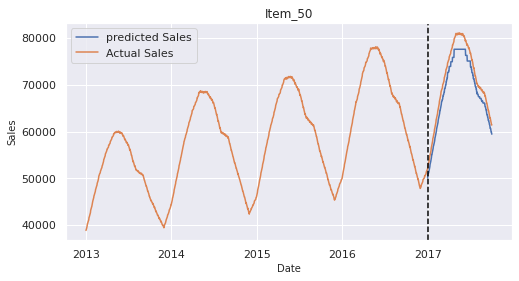

In [27]:
#visualize the predicted and actual sales 
for k,v in test_forecast_dict_dt.items():
  plotdf_dt = pd.DataFrame(v, index=pd.date_range(start='2017-01-01', end='2017-10-02'))
  fig, ax = plt.subplots(figsize=(8,4))
  plt.title('{}'.format(k))
  plt.plot(plotdf_dt, label='predicted Sales')
  plt.plot(split_data_dt.sales, label='Actual Sales')
  plt.xlabel('Date', size=10)
  plt.ylabel('Sales', size=10)  
  ax.axvline(pd.to_datetime('2017-01-01'), color='black', ls='--')  # convert date string to datetime object
  plt.legend(loc='best')
  plt.show()


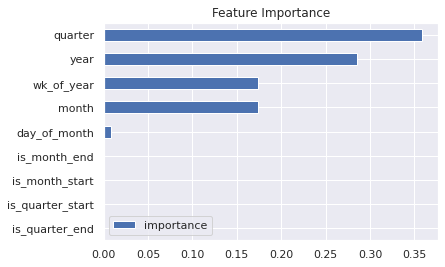

In [28]:
fi = pd.DataFrame(data=dtr_model.feature_importances_,
             index=dtr_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()